In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.stattools as stattools
import math

In [2]:
# Import for cointegration
from arch.unitroot.cointegration import engle_granger

In [3]:
df = pd.read_csv("../prices.txt", sep='\s+', header=None, index_col=None)
df.rename(columns=lambda c: str(c), inplace=True)
df["time"] = pd.to_datetime([i for i in range(750)], unit='D', origin=pd.Timestamp('2020-01-01'))
df.set_index("time", inplace=True)
df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
time,,,,,,,,,,,,,,,,,,,,,
2020-01-01,13.46,71.65,48.46,50.52,52.10,13.00,18.98,47.71,69.49,49.96,...,32.64,55.76,14.46,58.94,36.71,52.62,49.33,36.22,49.00,56.09
2020-01-02,13.48,72.10,48.52,50.50,52.06,12.95,18.95,47.84,69.73,49.93,...,32.52,55.97,14.44,59.81,36.64,52.58,49.20,36.27,48.84,56.08
2020-01-03,13.47,72.35,48.48,50.62,51.80,12.79,18.98,47.98,69.60,49.33,...,32.48,56.34,14.50,59.04,36.89,52.49,49.48,36.39,48.56,55.90
2020-01-04,13.53,72.51,48.42,50.75,51.66,12.66,18.96,48.74,69.54,49.67,...,32.59,56.32,14.40,58.73,36.94,52.40,49.42,36.41,49.00,56.14
2020-01-05,13.64,71.99,48.40,50.65,51.97,12.62,18.89,48.88,69.68,49.46,...,32.64,56.32,14.36,59.01,37.03,52.44,49.79,36.42,48.14,55.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-15,10.32,63.28,45.54,43.35,52.64,7.91,17.30,55.30,67.83,58.73,...,28.81,79.78,10.85,61.76,30.12,48.51,82.09,34.95,35.80,52.57
2022-01-16,10.32,63.34,45.56,43.28,52.73,7.87,17.26,54.92,67.95,58.62,...,28.78,80.46,10.77,61.49,29.85,48.40,81.43,34.99,35.58,53.10
2022-01-17,10.32,63.23,45.55,43.25,52.66,7.83,17.32,54.67,67.94,59.15,...,28.73,81.15,10.75,60.36,29.77,48.41,81.90,35.00,35.45,53.21


In [4]:
preTrain = df[:500][:]
preTest = df[500:750][:]

In [5]:
train = np.log(preTrain)
test = np.log(preTest)

In [14]:
# Check if stationary
# Non-stationary
def test_stationary(series, printing=False):
    dftest = stattools.adfuller(series, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    if printing:
        print("Results of Dickey-Fuller Test:")
        print(dfoutput)

    
    kpsstest = stattools.kpss(series, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    if printing:
        print("Results of KPSS Test:")
        print(kpss_output)
    
    isStationary = dfoutput["p-value"] < 0.07 and kpss_output["p-value"] > 0.07
    if printing:
        print("STATIONARY: ", isStationary)    

    return (dfoutput["p-value"], kpss_output["p-value"], isStationary)

In [7]:
# Find cointegrated pair with statsmodel
threshold = 0.05

coint_pairs = []
train_coint_matrix = [[-1] * 50 for i in range(50)]
test_coint_matrix = [[-1] * 50 for i in range(50)]
for i in range(50):
    for j in range(i+1, 50):
        train_coint_pVal = stattools.coint(train[str(i)], train[str(j)])[1]
        test_coint_pVal = stattools.coint(test[str(i)], test[str(j)])[1]
        train_coint_matrix[i][j] = train_coint_pVal
        test_coint_matrix[i][j] = test_coint_pVal

        if (train_coint_pVal < threshold and test_coint_pVal < threshold):
            coint_pairs.append((i, j))

print(coint_pairs)


[(1, 10), (14, 27), (14, 36), (14, 38), (14, 44), (28, 49)]


In [17]:
# Get the cointegration vectors with engle_granger
threshold = 0.1
coint_vecs = {}
pairs = []
for i in range(50):
    for j in range(i+1, 50):
        pair = (i, j)
        result = engle_granger(train[str(pair[0])], train[str(pair[1])], trend='c', method='bic')
        testTest = engle_granger(test[str(pair[0])], test[str(pair[1])], trend='c', method='bic')
        if result.pvalue < threshold and testTest.pvalue < threshold:
            coint_vecs[pair] = result.cointegrating_vector[:2]
            print(pair, result.pvalue, testTest.pvalue)
            print(result.cointegrating_vector)
            pairs.append(pair)

(7, 26) 0.024925178784359427 0.09203039087279641
7        1.000000
26      -0.072094
const   -3.550536
dtype: float64
(14, 18) 0.07644669472753349 0.0122074615536204
14       1.000000
18      -0.814115
const   -0.560081
dtype: float64
(14, 23) 0.05946115301557321 0.014716902041355517
14       1.000000
23      -0.742745
const   -0.174548
dtype: float64
(14, 27) 0.012489164347395696 0.009353755692627436
14       1.000000
27      -2.867138
const    6.954252
dtype: float64
(14, 29) 0.05630313989231385 0.017564635286982464
14       1.000000
29      -1.668275
const    3.050140
dtype: float64
(14, 36) 0.03574645254464612 0.018711975187932304
14       1.000000
36       0.501417
const   -4.488761
dtype: float64
(14, 38) 0.045493952004648265 0.01081109797500136
14       1.000000
38      -3.885433
const    9.239258
dtype: float64
(14, 42) 0.08170608133992091 0.01982588105206217
14       1.000000
42      -0.599958
const   -1.177410
dtype: float64
(14, 44) 0.03334381932354816 0.0164716199221991
14 

(11, 42)
(1, 10)


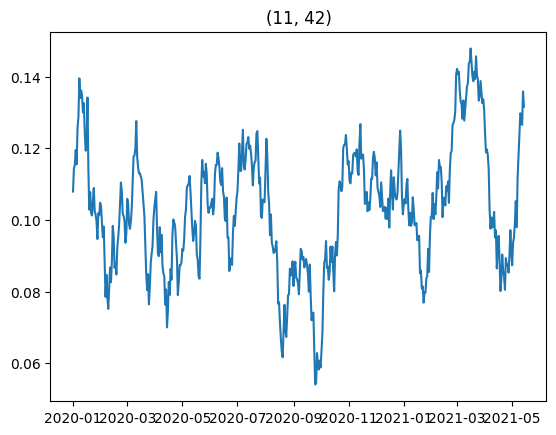

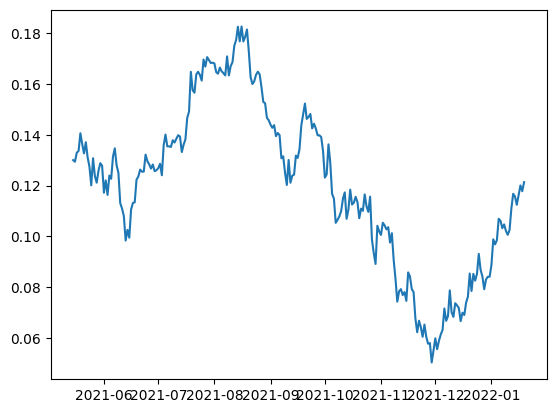

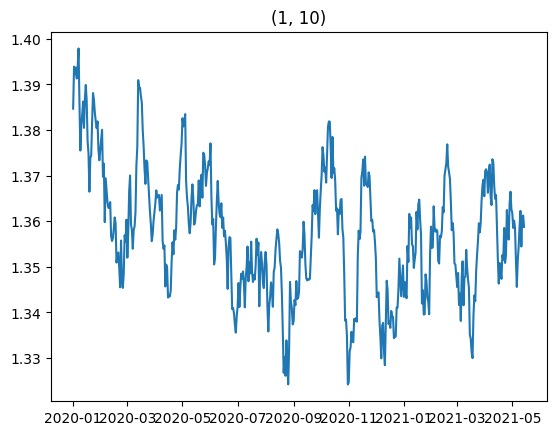

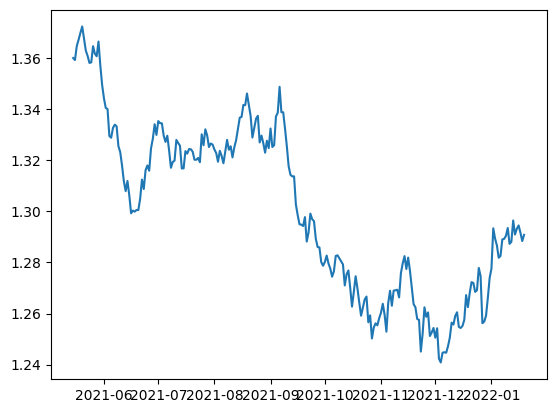

In [23]:
# Test previous pair - Doesn't fit at all
# pair_trade(df, 11, 42, [0.45263609, -0.54736391], 0.026805109292277557)
# pair_trade(df, 1, 10, [0.63057265, -0.36942735], 0.019607962852651883)
# pair_trade(df, 4, 32, [0.4989909853629603, -0.5010090146370396], 0.008144572661827587)
# pair_trade(df, 24, 49, [0.4927626542556702, -0.5072373457443298])
# pair_trade(df, 22, 47, [0.4570128708881386, -0.5429871291118614])
pairs = [(11, 42), (1, 10)]
betas = [[0.45263609, -0.54736391], [0.63057265, -0.36942735]]
for i in range(len(pairs)):
    pair = pairs[i]
    print(pair)
    # print(coint_vecs[pair])
    # beta = coint_vecs[pair].values
    beta = betas[i]
    residualTrain = beta[0] * train[str(pair[0])] + beta[1] * train[str(pair[1])]
    residualTest = beta[0] * test[str(pair[0])] + beta[1] * test[str(pair[1])]
    # if test_stationary(residualTrain, printing=False)[2] and test_stationary(residualTest, printing=False)[2]:
    plt.figure()
    plt.title(pair)
    plt.plot(residualTrain)
    plt.figure()
    plt.plot(residualTest)